In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

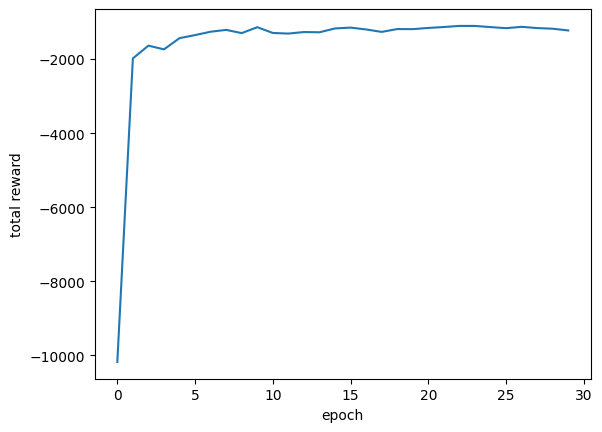

big epoch: 29 small epoch: 0 Loss 0.00012078918547355577
big epoch: 29 small epoch: 1 Loss 4.407759836049353e-05
big epoch: 29 small epoch: 2 Loss 5.2114491972695116e-05
big epoch: 29 small epoch: 3 Loss 3.15567661394254e-05
big epoch: 29 small epoch: 4 Loss 2.6587892968161106e-05
big epoch: 29 small epoch: 5 Loss 2.5359232208210626e-05
big epoch: 29 small epoch: 6 Loss 2.568200759837046e-05
big epoch: 29 small epoch: 7 Loss 2.449184499363011e-05
big epoch: 29 small epoch: 8 Loss 2.4503905084049495e-05
big epoch: 29 small epoch: 9 Loss 2.4545603513419306e-05
big epoch: 29 small epoch: 10 Loss 2.375919551044869e-05
big epoch: 29 small epoch: 11 Loss 2.4373368722657162e-05
big epoch: 29 small epoch: 12 Loss 2.3448919255001712e-05
big epoch: 29 small epoch: 13 Loss 2.4995252522461726e-05
big epoch: 29 small epoch: 14 Loss 2.4328904777415026e-05
big epoch: 29 small epoch: 15 Loss 2.881289593417976e-05
big epoch: 29 small epoch: 16 Loss 2.5732688522037846e-05
big epoch: 29 small epoch: 17 L

In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

#policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=4, inner_epochs=20, alpha_a=1e-5, init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 
policy = train_pods(env,trajectory_length=100 ,num_samples=100,epochs=30, inner_epochs=20, alpha_a=8e-5, init_learning_rate=1e-3, progress_fn=progress_f)

In [6]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333333]
[0.33333309]
[0.33332854]
[0.33329246]
[0.3332316]
[0.33290428]
[0.32493495]
[0.06632367]
[-0.00770305]
[-0.10398655]
[-0.14828219]
[-0.21093229]
[-0.24248575]
[-0.25676316]
[-0.26838393]
[-0.27202898]
[-0.27084284]
[-0.2693598]
[-0.26818429]
[-0.26820601]
[-0.27689547]
[-0.28656023]
[-0.29067543]
[-0.28477211]
[-0.26402038]
[-0.2276058]
[-0.16589029]
[-0.12008348]
[-0.07994961]
[-0.04974974]
[-0.02880224]
[-0.01080478]
[0.00305998]
[0.01259889]
[0.02069818]
[0.02701074]
[0.03056244]
[0.03393822]
[0.03447475]
[0.03437989]
[0.03363345]
[0.03204229]
[0.02886181]
[0.02556981]
[0.02201447]
[0.01790746]
[0.01342287]
[0.00879044]
[0.0041873]
[-0.00014009]
[-0.0034997]
[-0.00692387]
[-0.01056326]
[-0.01369752]
[-0.0170518]
[-0.01996908]
[-0.02174116]

In [9]:
yes=html.render(env.sys.replace(), rollout)
with open("data.html", "w") as file:
    file.write(yes)